In [1]:
# load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io # import tiff file as ndarray
from STP_functions_Copy1 import make_mask # user (Emily) defined function
# from STP_functions_Copy1 import calc_roi_fluoresence
import pickle
from skimage.segmentation import find_boundaries # for generating boundaries
# from palettable.cartocolors.sequential import Magenta_7 # for magenta colormap (not purples)
from scipy.ndimage import gaussian_filter # for applying gaussian filter for density plots

# for custom colormaps
from matplotlib import cm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

# save as tiff file
# from tifffile import imwrite
from time import time


inpath = "/Volumes/Data/Emily/STP_images/0_OMC_ACA_compare/mmus/"
outpath = "/Volumes/Data/Emily/STP_images/0_OMC_ACA_compare/mmus/python/output/"

# import tif files
mmus_omc = io.imread(inpath+"OMC_Mmus_b1_norm_subtract.tif", plugin="tifffile")
mmus_aca = io.imread(inpath+"230404_ACA_mmus_b2_norm_subtract.tif", plugin="tifffile")
reg_atlas = io.imread(inpath+"mmus_registered_atlas_sized.tif", plugin="tifffile")
# boundaries = io.imread(inpath+"mmus_boundaries_sized.tiff", plugin="tifffile")

data = [mmus_omc, mmus_aca]
titles = ["OMC", "ACA"]

# set image parameters
ar = 1 # aspect ratio of all images
gs = 3 # sigma to use for gaussian smoothing
save_dpi = 300

In [2]:
# import masks
start = time()

with open(outpath + 'mmus_grey.pkl', 'rb') as f:
    grey = pickle.load(f)

with open(outpath + 'mmus_ctx.pkl', 'rb') as f:
    ctx = pickle.load(f)

with open(outpath + 'mmus_th.pkl', 'rb') as f:
    th = pickle.load(f)

with open(outpath + 'mmus_stri.pkl', 'rb') as f:
    stri = pickle.load(f)

with open(outpath + 'mmus_cp.pkl', 'rb') as f:
    cp = pickle.load(f)
    
with open(outpath + 'mmus_pons.pkl', 'rb') as f:
    pons = pickle.load(f)

with open(outpath + 'mmus_mb.pkl', 'rb') as f:
    mb = pickle.load(f)

with open(outpath + 'mmus_hy.pkl', 'rb') as f:
    hy = pickle.load(f)

with open(outpath + 'mmus_pag.pkl', 'rb') as f:
    pag = pickle.load(f)
    
with open(outpath + 'mmus_cnu.pkl', 'rb') as f:
    cnu = pickle.load(f)

end = time()

print("script took", end-start, "seconds")

script took 228.37785816192627 seconds


In [3]:
# create custom green/purple colormaps to match adobe illustrator chosen colors
N = 256
purple = np.ones((N, 4))
purple[:, 0] = np.linspace(1, 146/256, N) # R = 146
purple[:, 1] = np.linspace(1, 39/256, N) # G = 39
purple[:, 2] = np.linspace(1, 143/256, N)  # B = 143
purple_cmp = ListedColormap(purple)

green = np.ones((N, 4))
green[:, 0] = np.linspace(1, 5/256, N) # R = 5
green[:, 1] = np.linspace(1, 104/256, N) # G = 104
green[:, 2] = np.linspace(1, 57/256, N)  # B = 57
green_cmp = ListedColormap(green)

In [56]:
orange = np.ones((N, 4))
orange[:, 0] = np.linspace(1, 242/256, N) # R = 242
orange[:, 1] = np.linspace(1, 101/256, N) # G = 101
orange[:, 2] = np.linspace(1, 34/256, N)  # B = 34
orange_cmp = ListedColormap(orange)

blue = np.ones((N, 4))
blue[:, 0] = np.linspace(1, 33/256, N) # R = 33
blue[:, 1] = np.linspace(1, 64/256, N) # G = 64
blue[:, 2] = np.linspace(1, 154/256, N)  # B = 154
blue_cmp = ListedColormap(blue)

In [57]:
# make definitions

def slice_boundaries(mask_list, roi_mask, scaling_factor=1000, boundary_mode="thick"):
    """
    Create outlines of regions for region of interest
    
    mask_list = list of masks to use to create boundaries,
                make sure list order is in order want to stack masks in final image            
    roi_mask = the roi being plotted, to adjust for z depth
                or scalar for slice to be taken of
    scaling_factor = how much to scale the final boundary value to make visible when plotting
    boudnary_mode = mode used to make boundaries, 
                    inherited from skimage.segmentation.find_boudnaries
    """
    
    if type(roi_mask) == int:
        roi_idx = roi_mask
    else:
        roi_idx = roi_mask.sum(axis=1).sum(axis=1) > 0
        
    masks_roi = [m[roi_idx] for m in mask_list]
    
    if type(roi_mask) == int:
        masks_max = masks_roi
    else:
        masks_max = [m.max(axis=0) for m in masks_roi]
    masks_max_adj = [np.where(masks_max[i] == 1,i+1,0) for i in range(len(masks_max))]

    slice_mask = masks_max_adj[0] # initailize
    for i in range(1,len(mask_list)):
        slice_mask = np.maximum(slice_mask, masks_max_adj[i]) # add masks on top

    slice_boundaries = find_boundaries(slice_mask.astype(int), mode=boundary_mode).astype(
        np.int8, copy=False)
    
    slice_bind = np.where(slice_boundaries > 0, slice_boundaries*scaling_factor, 0)


    return slice_mask, slice_bind



In [58]:
omc_pag = np.multiply(mmus_omc,pag)
aca_pag = np.multiply(mmus_aca,pag)

print(omc_pag.max())
print(aca_pag.max())

2325.0
1283.0


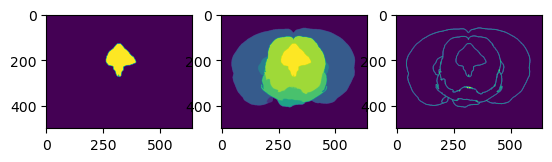

In [59]:
pag_idx = pag.sum(axis=1).sum(axis=1) > 0

# STR slice outline
pag_mask_list = [grey, ctx, th, hy, pons, mb, pag]

pag_slice_mask, pag_slice_boundaries = slice_boundaries(pag_mask_list, pag, scaling_factor=1000)
    

fig, axs = plt.subplots(1,3)
axs[0].imshow(pag.max(axis=0))
axs[1].imshow(pag_slice_mask)
# plt.colorbar()
axs[2].imshow(pag_slice_boundaries)
# plt.colorbar()

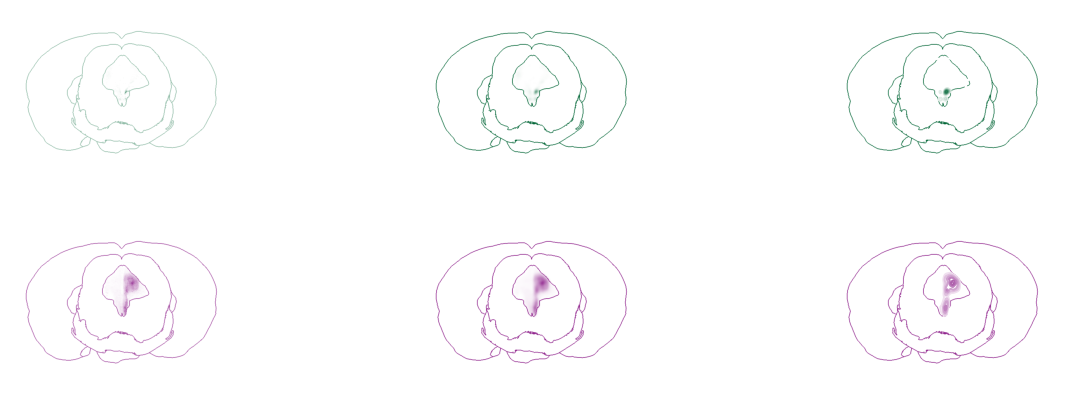

In [60]:
fig, axs = plt.subplots(2,3, figsize=[15,5])

# OMC
plot_omc = omc_pag.max(axis=0)
blur_omc = gaussian_filter(plot_omc, sigma=gs)

axs[0,0].imshow(np.maximum(plot_omc,pag_slice_boundaries), cmap=green_cmp, aspect=ar)
axs[0,0].axis('off')

axs[0,1].imshow(np.maximum(blur_omc,pag_slice_boundaries), cmap=green_cmp, aspect=ar)
axs[0,1].axis('off')

axs[0,2].contour(blur_omc, cmap=green_cmp)
axs[0,2].set_aspect(ar)
axs[0,2].axis('off')
axs[0,2].imshow(pag_slice_boundaries, cmap=green_cmp, aspect=ar)

# ACA
plot_aca = aca_pag.max(axis=0)
blur_aca = gaussian_filter(plot_aca, sigma=gs)

axs[1,0].imshow(np.maximum(plot_aca, pag_slice_boundaries), cmap=purple_cmp, aspect=ar)
axs[1,0].axis('off')

axs[1,1].imshow(np.maximum(blur_aca, pag_slice_boundaries), cmap=purple_cmp, aspect=ar)
axs[1,1].axis('off')

axs[1,2].contour(blur_aca, cmap=purple_cmp)
axs[1,2].set_aspect(ar)
axs[1,2].axis('off')
axs[1,2].imshow(pag_slice_boundaries, cmap=purple_cmp, aspect=ar)


plt.show()
fig.savefig(outpath+"mmus_pag_max.jpeg", dpi=save_dpi)

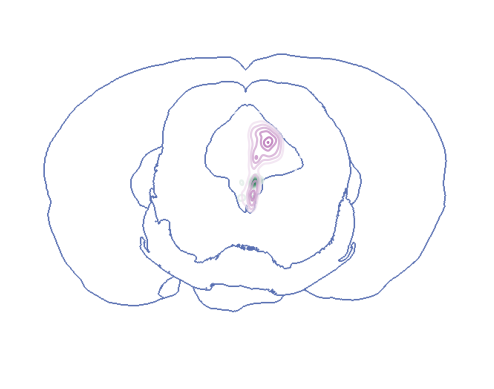

In [62]:
# densities on top of eachother

plot_omc = omc_pag.max(axis=0)
blur_omc = gaussian_filter(plot_omc, sigma=gs)

plot_aca = aca_pag.max(axis=0)
blur_aca = gaussian_filter(plot_aca, sigma=gs)

plt.contour(blur_omc, cmap=green_cmp, alpha=0.75)
plt.gca().set_aspect(ar)
plt.axis('off')

plt.contour(blur_aca, cmap=purple_cmp, alpha=0.75)
plt.gca().set_aspect(ar)
plt.axis('off')

plt.imshow(pag_slice_boundaries, cmap=blue_cmp, alpha=0.75, aspect=ar)

plt.savefig(outpath+"mmus_pag_densities.jpeg", dpi=save_dpi)

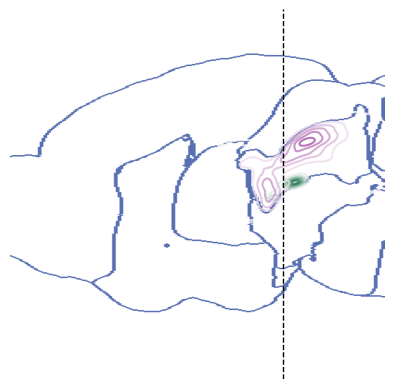

In [69]:
pag_mask_list = [grey, ctx, th, pons, mb, pag]

# aspect ratio of saggittal sections
ar_sag = 1/2.5 # 20 x 50 um

# transpose masks to sagittal orientation
pag_sag = np.transpose(pag, (2,1,0))
pag_mask_list_sag = [np.transpose(m, (2,1,0)) for m in pag_mask_list]

# transpose data to sagittal orientation
mmus_omc_sag = np.transpose(mmus_omc, (2,1,0))
mmus_aca_sag = np.transpose(mmus_aca, (2,1,0))

# isolate pagatum
omc_pag_sag = np.multiply(mmus_omc_sag,pag_sag)
aca_pag_sag = np.multiply(mmus_aca_sag,pag_sag)

# get indices for sag slices w/ pagatum
pag_idx_sag = pag_sag.sum(axis=1).sum(axis=1) > 0

# STR slice outline
pag_slice_mask, pag_slice_boundaries = slice_boundaries(pag_mask_list_sag, pag_sag, scaling_factor=25000)
    

# fig, axs = plt.subplots(1,3)
# axs[0].imshow(pag_sag.max(axis=0), aspect=ar_sag)
# axs[1].imshow(pag_slice_mask, aspect=ar_sag)
# # plt.colorbar()
# axs[2].imshow(pag_slice_boundaries, aspect=ar_sag)
# # plt.colorbar()

# densities on top of eachother

plot_omc = omc_pag_sag.max(axis=0)
blur_omc = gaussian_filter(plot_omc, sigma=gs)

plot_aca = aca_pag_sag.max(axis=0)
blur_aca = gaussian_filter(plot_aca, sigma=gs)

plt.contour(blur_omc, cmap=green_cmp, alpha=0.75)
plt.gca().set_aspect(ar_sag)
plt.axis('off')

plt.contour(blur_aca, cmap=purple_cmp, alpha=0.75)
plt.gca().set_aspect(ar_sag)
plt.axis('off')

plt.imshow(pag_slice_boundaries, cmap=blue_cmp, alpha=0.75, aspect=ar_sag)
plt.axvline(x=147, linewidth=1, linestyle="--", color='black')
plt.savefig(outpath+"mmus_pag_sagittal.jpeg", dpi=save_dpi)

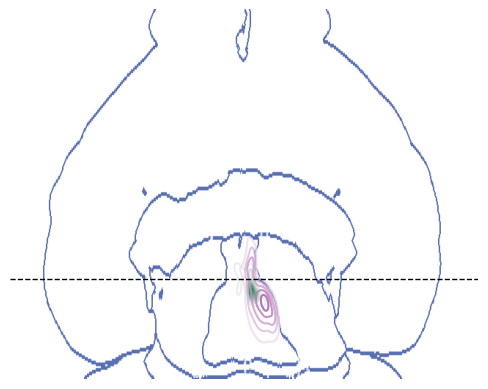

In [68]:
# aspect ratio of trangittal sections
ar_tran = 2.5 # 20 x 50 um

# transpose masks to tranittal orientation
pag_tran = np.transpose(pag, (1,0,2))
pag_mask_list_tran = [np.transpose(m, (1,0,2)) for m in pag_mask_list]

# transpose data to tranittal orientation
mmus_omc_tran = np.transpose(mmus_omc, (1,0,2))
mmus_aca_tran = np.transpose(mmus_aca, (1,0,2))

# isolate pagatum
omc_pag_tran = np.multiply(mmus_omc_tran,pag_tran)
aca_pag_tran = np.multiply(mmus_aca_tran,pag_tran)

# get indices for tran slices w/ pagatum
pag_idx_tran = pag_tran.sum(axis=1).sum(axis=1) > 0

# STR slice outline
pag_slice_mask, pag_slice_boundaries = slice_boundaries(pag_mask_list_tran, pag_tran, scaling_factor=25000)
    

# fig, axs = plt.subplots(1,3)
# axs[0].imshow(pag_tran.max(axis=0), aspect=ar_tran)
# axs[1].imshow(pag_slice_mask, aspect=ar_tran)
# # plt.colorbar()
# axs[2].imshow(pag_slice_boundaries, aspect=ar_tran)
# # plt.colorbar()
# densities on top of eachother

plot_omc = omc_pag_tran.max(axis=0)
blur_omc = gaussian_filter(plot_omc, sigma=gs)

plot_aca = aca_pag_tran.max(axis=0)
blur_aca = gaussian_filter(plot_aca, sigma=gs)

plt.contour(blur_omc, cmap=green_cmp, alpha=0.75)
plt.gca().set_aspect(ar_tran)
plt.axis('off')

plt.contour(blur_aca, cmap=purple_cmp, alpha=0.75)
plt.gca().set_aspect(ar_tran)
plt.axis('off')

plt.imshow(pag_slice_boundaries, cmap=blue_cmp, alpha=0.75, aspect=ar_tran)
plt.axhline(y=147, linewidth=1, linestyle="--", color='black')

plt.savefig(outpath+"mmus_pag_transverse.jpeg", dpi=save_dpi)

# seperate PAG into anterior/posterior

In [66]:
pag_sum = pag.sum(axis=1).sum(axis=1)
pag_sum

array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 

In [70]:
# pag starts 122
# pag ends 195
pag_sum[122:195]

array([2.000e+00, 1.190e+02, 2.860e+02, 5.080e+02, 6.730e+02, 8.090e+02,
       8.420e+02, 1.004e+03, 1.312e+03, 1.566e+03, 1.747e+03, 1.861e+03,
       1.946e+03, 2.053e+03, 2.121e+03, 2.175e+03, 2.153e+03, 2.082e+03,
       1.997e+03, 1.902e+03, 1.830e+03, 1.775e+03, 1.753e+03, 1.785e+03,
       1.916e+03, 2.008e+03, 2.118e+03, 2.183e+03, 2.297e+03, 2.441e+03,
       2.594e+03, 2.777e+03, 2.980e+03, 3.174e+03, 3.346e+03, 3.461e+03,
       3.542e+03, 3.737e+03, 3.860e+03, 4.007e+03, 4.156e+03, 4.299e+03,
       4.406e+03, 4.421e+03, 4.428e+03, 4.492e+03, 4.575e+03, 4.642e+03,
       4.762e+03, 4.929e+03, 5.164e+03, 5.369e+03, 5.442e+03, 5.575e+03,
       5.717e+03, 5.897e+03, 6.082e+03, 6.287e+03, 6.498e+03, 6.692e+03,
       6.827e+03, 6.695e+03, 6.360e+03, 6.220e+03, 6.215e+03, 5.889e+03,
       5.384e+03, 4.855e+03, 3.974e+03, 2.703e+03, 1.346e+03, 3.220e+02,
       1.800e+01])

73
25


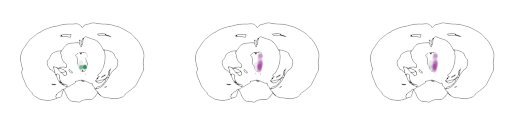

In [71]:
apag_include = list(range(122, 147))
print(((pag.sum(axis=1).sum(axis=1)) > 0 ).sum())
apag_keep = np.zeros_like(pag)
apag_keep[apag_include] = np.ones_like(apag_keep[apag_include])
print(((apag_keep.sum(axis=1).sum(axis=1)) > 0 ).sum())
apag_use = pag*apag_keep

omc_apag = np.multiply(mmus_omc,apag_use)
aca_apag = np.multiply(mmus_aca,apag_use)

apag_slice_mask, apag_slice_boundaries = slice_boundaries(pag_mask_list, apag_use, scaling_factor=25000)
    

# fig, axs = plt.subplots(1,3)
# axs[0].imshow(apag_use.max(axis=0))
# axs[1].imshow(apag_slice_mask)
# # plt.colorbar()
# axs[2].imshow(apag_slice_boundaries)
# # plt.colorbar()

# densities on top of eachother
fig, axs = plt.subplots(1,3)

plot_omc = omc_apag.max(axis=0)
blur_omc = gaussian_filter(plot_omc, sigma=gs)

plot_aca = aca_apag.max(axis=0)
blur_aca = gaussian_filter(plot_aca, sigma=gs)

axs[0].contour(blur_omc, cmap=green_cmp, alpha=0.75)
axs[0].set_aspect(ar)
axs[0].axis('off')
axs[0].imshow(apag_slice_boundaries, cmap="Greys", aspect=ar)

axs[1].contour(blur_aca, cmap=purple_cmp, alpha=0.75)
axs[1].set_aspect(ar)
axs[1].axis('off')
axs[1].imshow(apag_slice_boundaries, cmap="Greys", aspect=ar)

axs[2].contour(blur_omc, cmap=green_cmp, alpha=0.75)
axs[2].set_aspect(ar)
axs[2].axis('off')

axs[2].contour(blur_aca, cmap=purple_cmp, alpha=0.75)
axs[2].set_aspect(ar)
axs[2].axis('off')
axs[2].imshow(apag_slice_boundaries, cmap="Greys", aspect=ar)

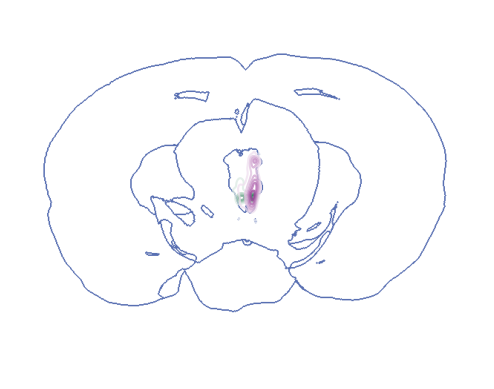

In [72]:
plot_omc = omc_apag.max(axis=0)
blur_omc = gaussian_filter(plot_omc, sigma=gs)

plot_aca = aca_apag.max(axis=0)
blur_aca = gaussian_filter(plot_aca, sigma=gs)

plt.contour(blur_omc, cmap=green_cmp, alpha=0.75)
# plt.gca().set_aspect(ar)
plt.axis('off')

plt.contour(blur_aca, cmap=purple_cmp, alpha=0.75)
# plt.gca().set_aspect(ar)
plt.axis('off')
plt.imshow(apag_slice_boundaries, cmap=blue_cmp, alpha=0.75)
plt.gca().set_aspect(1)

plt.savefig(outpath+"mmus_apag_densities.jpeg", dpi=save_dpi)

73
48


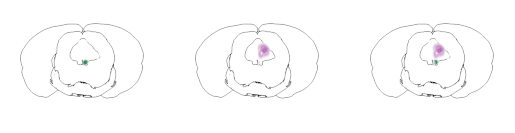

In [73]:
ppag_include = list(range(147, 195))
print(((pag.sum(axis=1).sum(axis=1)) > 0 ).sum())
ppag_keep = np.zeros_like(pag)
ppag_keep[ppag_include] = np.ones_like(ppag_keep[ppag_include])
print(((ppag_keep.sum(axis=1).sum(axis=1)) > 0 ).sum())
ppag_use = pag*ppag_keep

omc_ppag = np.multiply(mmus_omc,ppag_use)
aca_ppag = np.multiply(mmus_aca,ppag_use)

ppag_slice_mask, ppag_slice_boundaries = slice_boundaries(pag_mask_list, ppag_use, scaling_factor=25000)
    

# fig, axs = plt.subplots(1,3)
# axs[0].imshow(ppag_use.max(axis=0))
# axs[1].imshow(ppag_slice_mask)
# # plt.colorbar()
# axs[2].imshow(ppag_slice_boundaries)
# # plt.colorbar()

# densities on top of eachother
fig, axs = plt.subplots(1,3)

plot_omc = omc_ppag.max(axis=0)
blur_omc = gaussian_filter(plot_omc, sigma=gs)

plot_aca = aca_ppag.max(axis=0)
blur_aca = gaussian_filter(plot_aca, sigma=gs)

axs[0].contour(blur_omc, cmap=green_cmp, alpha=0.75)
axs[0].set_aspect(ar)
axs[0].axis('off')
axs[0].imshow(ppag_slice_boundaries, cmap="Greys", aspect=ar)

axs[1].contour(blur_aca, cmap=purple_cmp, alpha=0.75)
axs[1].set_aspect(ar)
axs[1].axis('off')
axs[1].imshow(ppag_slice_boundaries, cmap="Greys", aspect=ar)

axs[2].contour(blur_omc, cmap=green_cmp, alpha=0.75)
axs[2].set_aspect(ar)
axs[2].axis('off')

axs[2].contour(blur_aca, cmap=purple_cmp, alpha=0.75)
axs[2].set_aspect(ar)
axs[2].axis('off')
axs[2].imshow(ppag_slice_boundaries, cmap="Greys", aspect=ar)

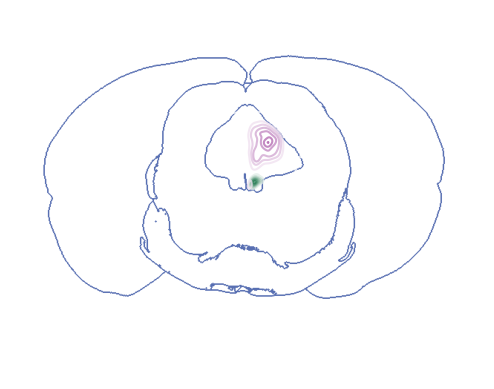

In [74]:
plot_omc = omc_ppag.max(axis=0)
blur_omc = gaussian_filter(plot_omc, sigma=gs)

plot_aca = aca_ppag.max(axis=0)
blur_aca = gaussian_filter(plot_aca, sigma=gs)

plt.contour(blur_omc, cmap=green_cmp, alpha=0.75)
# plt.gca().set_aspect(ar)
plt.axis('off')

plt.contour(blur_aca, cmap=purple_cmp, alpha=0.75)
# plt.gca().set_aspect(ar)
plt.axis('off')
plt.imshow(ppag_slice_boundaries, cmap=blue_cmp, alpha=0.75)
plt.gca().set_aspect(1)

plt.savefig(outpath+"mmus_ppag_densities.jpeg", dpi=save_dpi)